# Generating topography 
This notebook will run through the bare necessities for developing a higher resolution topography. 

Currently, this just takes the `hgrid.nc` from the ACCESS-OM2-01 input files, and multiplies the resolution of this by some factor. This example sets this factor to 3 in order to maintain consistency of tracer points between the high and low resolution grids. This justification may become unnecessary into the future. 


In [22]:
import xarray as xr
import xesmf as xe
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

# Set important directory paths
om2path = "/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/" ## Access om2_01 input for topography and hgrid
initpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077" ## Access om2_01 output for BCs and IC
toolpath = "/g/data/v45/ahg157/tools/" ## Compiled tools needed for construction of mask tables
    
from regional_model_scripts import input_datasets, interp_segment,prepare_segments, time_rotate,regrid_runoff,sel_hgrid_indices


from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46855/status,
Dashboard: /proxy/46855/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39771,Workers: 7
Dashboard: /proxy/46855/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:41645,Total threads: 1
Dashboard: /proxy/37623/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:44323,


#### Choose domain and set path to input and run directories...
- Taken from original notebook

In [31]:
!pwd

/home/581/jr5971


Text(0.5, 1.0, 'test_topog_ash domain')

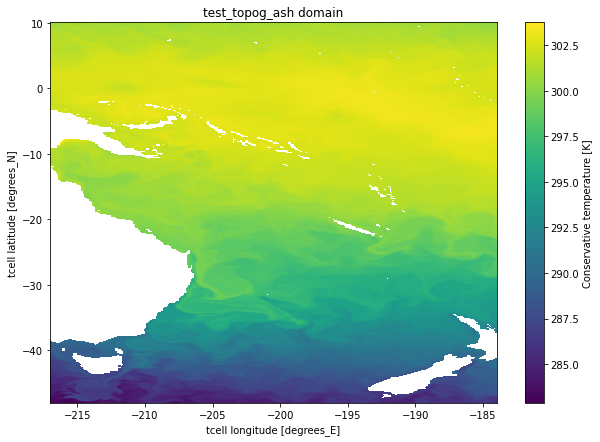

In [23]:
## Choose your coordinates and the name of your experiment
yextent = [-48, 10]
xextent = [-217 , -184]
expt_name = "test_topog_ash"

## Place where all your input files go
path = f"/scratch/v45/jr5971/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/581/jr5971/mom6_rundirs/{expt_name}"

for i in [path,rundir]:
    try:
        os.mkdir(i)
    except:
        pass

full_domain = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc")

# domain.tau_x.sel(yu_ocean=slice(-49, -5), xu_ocean=slice(-217, -183)).isel(time = 0).plot()
domain = full_domain.surface_temp.sel(yt_ocean=slice(yextent[0], yextent[1]), xt_ocean=slice(xextent[0],xextent[1])).isel(time = 0)
fig,ax = plt.subplots(1,figsize = (10,7))

domain.plot(ax = ax)
ax.set_title(f"{expt_name} domain")

# Key steps for generating higher res topog. 
## 1. Load in global hgrid from `om2path`, and cut this down to size for the domain extent

In [24]:
# Get new hgrid based on the geographical extent specified above
hgrid = xr.open_dataset(om2path + "ocean_hgrid.nc")

# get x and y indices of hgrid
x_indices_hgrid = sel_hgrid_indices(hgrid.x.isel(nyp = 1000,nxp = slice(0,None,2)),xextent)  ## As long as it's away from the north pole things are ok since lon doesn't vary with lat
y_indices_hgrid = sel_hgrid_indices(hgrid.y.isel(nxp = 0,nyp = slice(0,None,2)),yextent) 

encoding = {'x': {'_FillValue': None},
            'y': {'_FillValue': None},
            "dx": {"_FillValue": None},
            'dy': {'_FillValue': None},
            'angle_dx': {'_FillValue': None},
            'area': {'_FillValue': None}
            }  

hgrid_new = hgrid.isel(
    nyp = slice(y_indices_hgrid[0] , y_indices_hgrid[1] ),
    nxp = slice(x_indices_hgrid[0] , x_indices_hgrid[1] ),
    ny = slice(y_indices_hgrid[0] , y_indices_hgrid[1] - 1 ),
    nx = slice(x_indices_hgrid[0] , x_indices_hgrid[1] - 1 ))

### 2. Increase resolution of domain hgrid
Here, we take the original coordinate values in the x & y directions, divide the spaces between each consecutive pair by three, and add 2 more equally spaced values in between each original pair to get 3 times the original resolution. 
- We then create a meshgrid with these new values for both corner and tracer points and make a new dataset that has these new arrays representing the new lat and lon values

**NOTE**: All the printing was just a sanity check and can be removed eventually

In [25]:
x = hgrid_new.x.isel(nyp=0).values # get x-coordinate values
print(f"first five points of x on original supergrid are :{x[:5]}, \n and space between points is {round(x[1]-x[0],2)}")
xc = x[::2] # Select every second x-value, i.e the "corner points" of a staggered grid
xc3_delta = (xc[1:] - xc[:-1]) / 3 # Divide the space between each pair of points by three. 
xc3 = np.concatenate([xc, xc[:-1]+xc3_delta, xc[:-1]+2*xc3_delta]) # add in the extra variables. 
xc3 = np.sort(xc3)
print(f"\n first five new corner points of hgrid are: {xc3[:5]}, \n and space between points is {xc3[1]-xc3[0]}")
xt3 = (xc3[1:] + xc3[:-1])/2
print(f"\n first five new tracer points of hgrid are: {xt3[:5]}, \n and space between tracer points is {xt3[1]-xt3[0]}")
y = hgrid_new.y.isel(nxp=0).values
yc = y[::2]
yc3_delta = (yc[1:] - yc[:-1]) / 3
yc3 = np.sort(np.concatenate([yc, yc[:-1]+yc3_delta, yc[:-1]+2*yc3_delta]))
print(f"\n first five new corner points of hgrid are: {yc3[-5:]}, \n and space between points is {yc3[-1]-yc3[-2]}")
yt3 = (yc3[1:] + yc3[:-1])/2
print(f"\n first five new tracer points of hgrid are: {yt3[:5]}, \n and space between tracer points is {yt3[1]-yt3[0]}")
print(f"\n difference between the corner and tracer points in x are: {xt3[0]-xc3[0]} degrees longitude")

# broadcast to meshgrid
XC, YC = np.meshgrid(xc3, yc3)
XT, YT = np.meshgrid(xt3, yt3)

# create output dataset
ds = xr.Dataset({
    "grid_lon": (['grid_yc', 'grid_xc'], XC),
    'grid_lat': (['grid_yc', 'grid_xc'], YC),
    'grid_lont': (['grid_yt', 'grid_xt'], XT),
    'grid_latt': (['grid_yt', 'grid_xt'], YT),
})

ds.to_netcdf(path + 'grid_30th-deg.nc')

first five points of x on original supergrid are :[-217.   -216.95 -216.9  -216.85 -216.8 ], 
 and space between points is 0.05

 first five new corner points of hgrid are: [-217.         -216.96666667 -216.93333333 -216.9        -216.86666667], 
 and space between points is 0.03333333333333144

 first five new tracer points of hgrid are: [-216.98333333 -216.95       -216.91666667 -216.88333333 -216.85      ], 
 and space between tracer points is 0.03333333333330302

 first five new corner points of hgrid are: [9.81825729 9.85110404 9.88394098 9.91677792 9.94961486], 
 and space between points is 0.03283694084293032

 first five new tracer points of hgrid are: [-47.94946472 -47.92712888 -47.90479305 -47.88244275 -47.86007798], 
 and space between tracer points is 0.022335831512208415

 difference between the corner and tracer points in x are: 0.01666666666667993 degrees longitude


#### 2.2 Generate hgrid from high-res meshgrid created above

In [28]:
args = "--grid_type from_file --my_grid_file grid_30th-deg.nc".split(" ")
print("MAKE HGRID", subprocess.run([toolpath + "make_hgrid"] + args, cwd=path), sep="\n")

MAKE HGRID
CompletedProcess(args=['/g/data/v45/ahg157/tools/make_hgrid', '--grid_type', 'from_file', '--my_grid_file', 'grid_30th-deg.nc'], returncode=0)


### 3. Load in GEBCO2022 topography dataset, cut down to region of interest, and use FRE-tools to interpolate data onto higher resolution hgrid

In [29]:
gebco_path = '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc'
gebco_ds = xr.open_dataset(gebco_path)
geb_idx = {'W':xextent[0]+360, 'E':xextent[1]+360,
           'S':yextent[0], 'N':yextent[1]}
geb_eac = gebco_ds.sel(lon=slice(geb_idx['W'], geb_idx['E']),
                       lat=slice(geb_idx['S'], geb_idx['N']))['elevation']
geb_eac.attrs['missing_value'] = -1e20
geb_eac.to_netcdf(path+'gebco_eac.nc')

#### 3.2 Generate `ocean_mosaic.nc` from the horizontal hgrid

In [30]:
args = "--num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file horizontal_grid.nc".split(" ")

print("MAKE SOLO MOSAIC",subprocess.run([toolpath + "make_solo_mosaic"] + args, cwd=path), sep="\n")

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC
CompletedProcess(args=['/g/data/v45/ahg157/tools/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'horizontal_grid.nc'], returncode=0)


#### 3.3 Interpolating GEBCO2022 onto hi-res mosaic grid.
Here is where things get interesting - I had to re-compile the FRE-NCtools, activating MPI capabilities 
- See hive forum post: https://forum.access-hive.org.au/t/fre-nctools-make-topog-mpi-error-when-generating-topography/436/5
    - The path to these new tools is `/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_topog/`. 
    - However running this in the Jupyter notebook still didn't work, as it couldn't parallelise from within Python as I understand it. So, I set it up as a PBS job: The script can be found at this path in my scratch directory - `/scratch/v45/jr5971/mom6/regional_configs/mom6_003/mpi_topog`
    I'm just not entirely sure how to incorporate the PBS execution from within the JupyterLab environment. 
